In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Softmax, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

file_path = '/content/Sunlab-Faro-PV-2017-.csv'
data = pd.read_csv(file_path)

selected_features = [
    'Year', 'Month', 'Day', 'Hour', 'Minute',  # 时间特征
    'A_Vertical - Power DC [W]',
    'A_Optimal - Power DC [W]',
    'B_Optimal - Power DC [W]',
    'A_Horizontal - Power DC [W]',
    'B_Horizontal - Power DC [W]',
    'A_Vertical - Temperature [C]',
    'A_Optimal - Temperature [C]',
    'B_Vertical - Temperature [C]',
    'A_Vertical - Voltage DC [V]',
    'B_Horizontal - Voltage DC [V]'
]
# Label column
label_column = 'Status'

data_values = data[selected_features].values
labels = data[label_column].values

def check_data_validity(data, name):
    if np.isnan(data).any() or np.isinf(data).any():
        raise ValueError(f"{name} contains NaN or Inf values!")

check_data_validity(data_values, "Input Data")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data_values)

# Create Sliding Windows with Indices
def create_sliding_windows(data, labels, window_size):
    X, y, indices = [], [], []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:i + window_size])
        y.append(labels[i + window_size - 1])
        indices.append(i + window_size - 1)
    return np.array(X), np.array(y), np.array(indices)

window_size = 10
X_windows, y_windows, label_indices = create_sliding_windows(X_scaled, labels, window_size)

# Split Data Directly on Windows and Labels
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_windows, y_windows, label_indices, test_size=0.2, random_state=42, shuffle=True
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (79992, 10, 15)
y_train shape: (79992,)
X_test shape: (19999, 10, 15)
y_test shape: (19999,)


In [3]:
input_layer = Input(shape=(window_size, X_train.shape[2]))
encoded = LSTM(128, activation='relu', return_sequences=True)(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)

memory_slots = 200
memory_vectors = Dense(memory_slots, activation='relu')(encoded)
memory_weights = Softmax()(memory_vectors)
memory_output = Multiply()([memory_weights, memory_vectors])

decoded = RepeatVector(window_size)(memory_output)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_layer, output_layer)
optimizer = Adam(learning_rate=0.00005, clipvalue=1.0)
autoencoder.compile(optimizer=optimizer, loss='mse')

def build_discriminator(input_shape):
    discriminator_input = Input(shape=input_shape)
    x = LSTM(64, activation='relu', return_sequences=True)(discriminator_input)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation='relu', return_sequences=False)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification
    return Model(discriminator_input, output)

discriminator = build_discriminator((window_size, X_train.shape[2]))
discriminator.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

def build_predictor(input_shape):
    predictor_input = Input(shape=input_shape)
    x = LSTM(128, activation='relu', return_sequences=True)(predictor_input)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation='relu', return_sequences=False)(x)
    prediction = Dense(input_shape[-1])(x)
    return Model(predictor_input, prediction)

predictor = build_predictor((window_size, X_train.shape[2]))
predictor.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

In [4]:
# Adversarial Training
batch_size = 64
epochs =50
early_stopping_patience = 10
best_disc_val_loss = float('inf')
wait = 0

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    autoencoder.fit(
        X_train, X_train,
        epochs=1, batch_size=batch_size, validation_split=0.2,
        shuffle=True, callbacks=[early_stopping], verbose=0
    )
    X_fake = autoencoder.predict(X_train)

    # Check data validity
    check_data_validity(X_fake, "X_fake")

    X_combined = np.concatenate([X_train, X_fake], axis=0)
    y_combined = np.concatenate([np.ones(len(X_train)), np.zeros(len(X_fake))], axis=0)

    history = discriminator.fit(
        X_combined, y_combined,
        epochs=1, batch_size=batch_size, validation_split=0.2,
        shuffle=True, verbose=0
    )
    disc_val_loss = history.history['val_loss'][0]
    if disc_val_loss < best_disc_val_loss:
        best_disc_val_loss = disc_val_loss
        wait = 0
    else:
        wait += 1
    if wait >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break
    disc_loss, disc_accuracy = discriminator.evaluate(X_combined, y_combined, verbose=0)
    print(f"Discriminator - Loss: {disc_loss:.4f}, Accuracy: {disc_accuracy:.4f}")

print("Training complete.")

Epoch 1
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
Discriminator - Loss: 0.0040, Accuracy: 0.9989
Epoch 2
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0164, Accuracy: 0.9953
Epoch 3
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0079, Accuracy: 0.9970
Epoch 4
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0047, Accuracy: 0.9984
Epoch 5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0030, Accuracy: 0.9992
Epoch 6
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0025, Accuracy: 0.9994
Epoch 7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0028, Accuracy: 0.9994
Epoch 8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0036, Accuracy: 0.9989
Epoch 9
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0052, Accuracy: 0.9990
Epoch 10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Discriminator - Loss: 0.0067, Accuracy: 0.9980
Training complete.

In [5]:
# Train Predictor
predictor.fit(
    X_train, X_train[:, -1, :],
    epochs=50, batch_size=batch_size, validation_split=0.2,
    shuffle=True, callbacks=[early_stopping], verbose=1
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.1086 - val_loss: 0.0120
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0141 - val_loss: 0.0089
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0108 - val_loss: 0.0070
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 12/50
1000/1000 ━━━━━━

In [6]:
# Model Predictions
X_train_pred = autoencoder.predict(X_train)
X_train_forward_pred = predictor.predict(X_train)

X_test_pred = autoencoder.predict(X_test)
X_test_forward_pred = predictor.predict(X_test)

train_reconstruction_error = np.mean(np.power(X_train - X_train_pred, 2), axis=(1, 2))
train_prediction_error = np.mean(np.power(X_train[:, -1, :] - X_train_forward_pred, 2), axis=1)

test_reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))
test_prediction_error = np.mean(np.power(X_test[:, -1, :] - X_test_forward_pred, 2), axis=1)

# Dynamic Threshold Calculation
def dynamic_threshold(errors, window_size=50, percentile=85):
    thresholds = [np.percentile(errors[max(0, i - window_size):i + 1], percentile) for i in range(len(errors))]
    return np.array(thresholds)

# Compute dynamic thresholds for train and test sets
combined_test_error = 0.7 * test_reconstruction_error + 0.3 * test_prediction_error

combined_test_threshold = dynamic_threshold(combined_test_error, 50, 85)

y_test_pred = (combined_test_error > combined_test_threshold).astype(int)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


      Metric     Value
0    ROC-AUC  0.934791
1  Precision  0.976670
2     Recall  0.892523
3   F1-Score  0.932703
4   Accuracy  0.977949


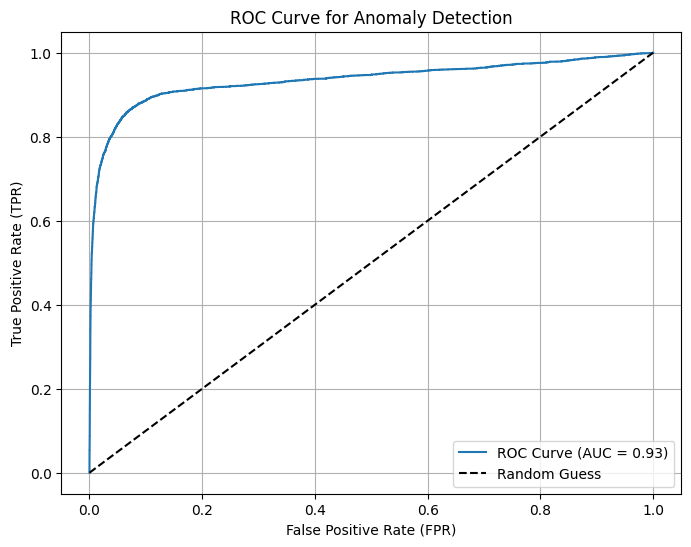


Confusion Matrix:
[[16502    73]
 [  368  3056]]


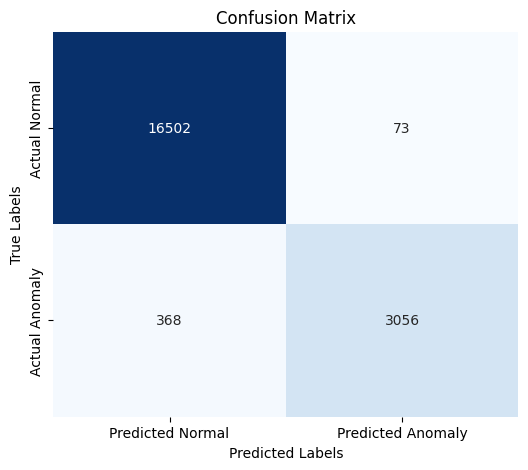

In [10]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

roc_auc = roc_auc_score(y_test, combined_test_error)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)

conf_matrix = confusion_matrix(y_test, y_test_pred)

fpr, tpr, thresholds = roc_curve(y_test, combined_test_error)

results_MemAAE = pd.DataFrame({
    "Metric": ["ROC-AUC", "Precision", "Recall", "F1-Score", "Accuracy"],
    "Value": [roc_auc, precision, recall, f1, accuracy]
})

roc_data = pd.DataFrame({"FPR": fpr, "TPR": tpr, "Thresholds": thresholds})
roc_file = "roc_curve_data.csv"
roc_data.to_csv(roc_file, index=False)

print(results_MemAAE)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Anomaly Detection")
plt.legend()
plt.grid()
plt.savefig("roc_curve_plot.png")
plt.show()
print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Normal", "Predicted Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_plot.png")
plt.show()